Starting hyperparameter tuning with GridSearchCV...
Fitting 5 folds for each of 729 candidates, totalling 3645 fits


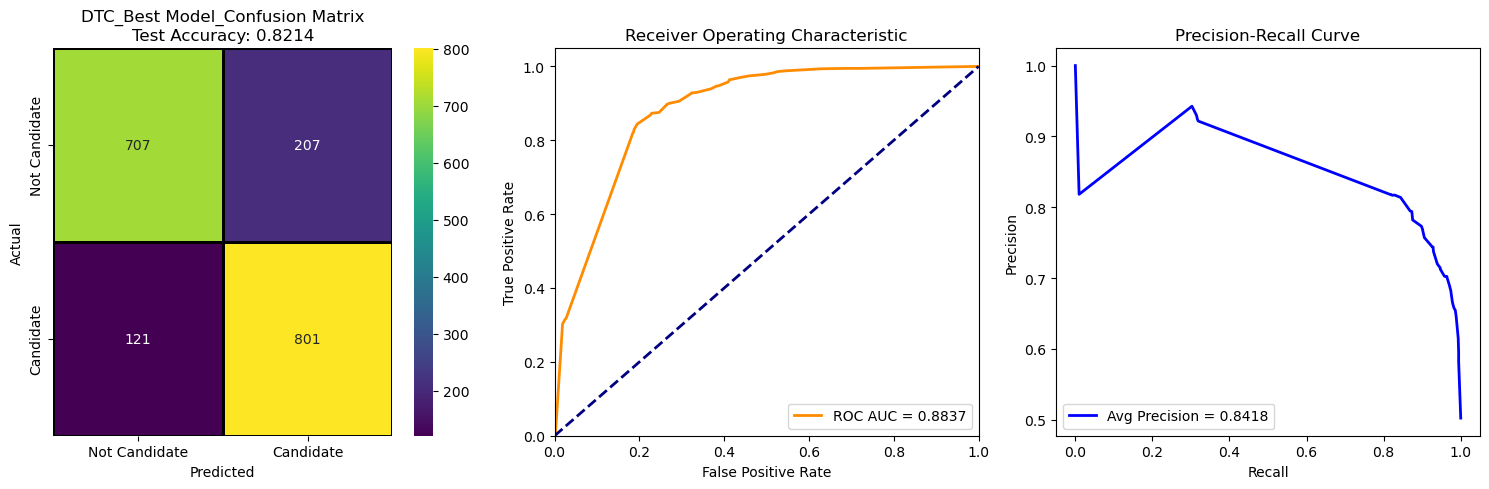


=== Best Model Summary ===
Best Parameters: {'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 14}
Cross-Validation Accuracy: 0.8148
Test Accuracy: 0.8214
ROC AUC Score: 0.8837
Average Precision Score: 0.8418

Classification Report:
               precision  recall  f1-score    support
Non-Candidate     0.8539  0.7735    0.8117   914.0000
Candidate         0.7946  0.8688    0.8301   922.0000
accuracy          0.8214  0.8214    0.8214     0.8214
macro avg         0.8243  0.8211    0.8209  1836.0000
weighted avg      0.8241  0.8214    0.8209  1836.0000


In [4]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)  # Sets 4 decimal places for all numpy outputs

# Load and preprocess data
short_cols = ['koi_period', 'koi_duration', 'koi_depth', 'koi_prad',
              'koi_teq', 'koi_insol', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smet', 'ExoplanetCandidate']

data = pd.read_csv('KOI_cumulative_2025.07.31_21.17.09.csv', comment='#')
data['ExoplanetCandidate'] = data['koi_pdisposition'].apply(lambda x: 1 if x == 'CANDIDATE' else 0)
data = data[short_cols].dropna()
data.to_csv('KOI_2025.07.31_cleaned.csv', index=False)

# Prepare features and target
X = data.drop(columns=['ExoplanetCandidate'])
y = data['ExoplanetCandidate']

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.2, stratify=y)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
joblib.dump(scaler, 'scaler_ksmet.sav')

# Set up parameter grid for GridSearchCV
param_grid = {
    'max_depth': range(2, 20, 2),
    'min_samples_split': range(2, 20, 2),
    'min_samples_leaf': range(2, 20, 2)
}

# Initialize and fit GridSearchCV
print("Starting hyperparameter tuning with GridSearchCV...")
dtc = DecisionTreeClassifier()
grid_search = GridSearchCV(dtc, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Save results and model
results_df = pd.DataFrame(grid_search.cv_results_)
results_df.to_csv('DTC_hyperparameter_tuning_results.csv', index=False)
joblib.dump(best_model, 'best_tuned_dtc_model.sav')

# Evaluate on test set
test_score = best_model.score(X_test, y_test)
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Generate evaluation plots
plt.figure(figsize=(15, 5))

# Confusion Matrix
plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="viridis", fmt="d", 
            linecolor="k", linewidths=1,
            xticklabels=['Not Candidate', 'Candidate'],
            yticklabels=['Not Candidate', 'Candidate'])
plt.title(f"DTC_Best Model_Confusion Matrix\nTest Accuracy: {test_score:.4f}")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# ROC Curve
plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc_score(y_test, y_proba):.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 3, 3)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)
plt.plot(recall, precision, color='blue', lw=2, 
         label=f'Avg Precision = {avg_precision:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.savefig('DTC_model_evaluation.png')
plt.show()

# Print final model summary
print("\n=== Best Model Summary ===")
print(f"Best Parameters: {best_params}")
print(f"Cross-Validation Accuracy: {best_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
print(f"Average Precision Score: {avg_precision:.4f}")
print("\nClassification Report:")
# Generate report as a dictionary
report_dict = classification_report(y_test, y_pred, target_names=['Non-Candidate', 'Candidate'], output_dict=True)

# Convert to DataFrame and round to 4 decimal places
report_df = pd.DataFrame(report_dict).transpose().round(4)
print(report_df)

Top Performing Configuration:
 param_max_depth  param_min_samples_split  param_min_samples_leaf  mean_test_score
               6                       14                      10         0.814764


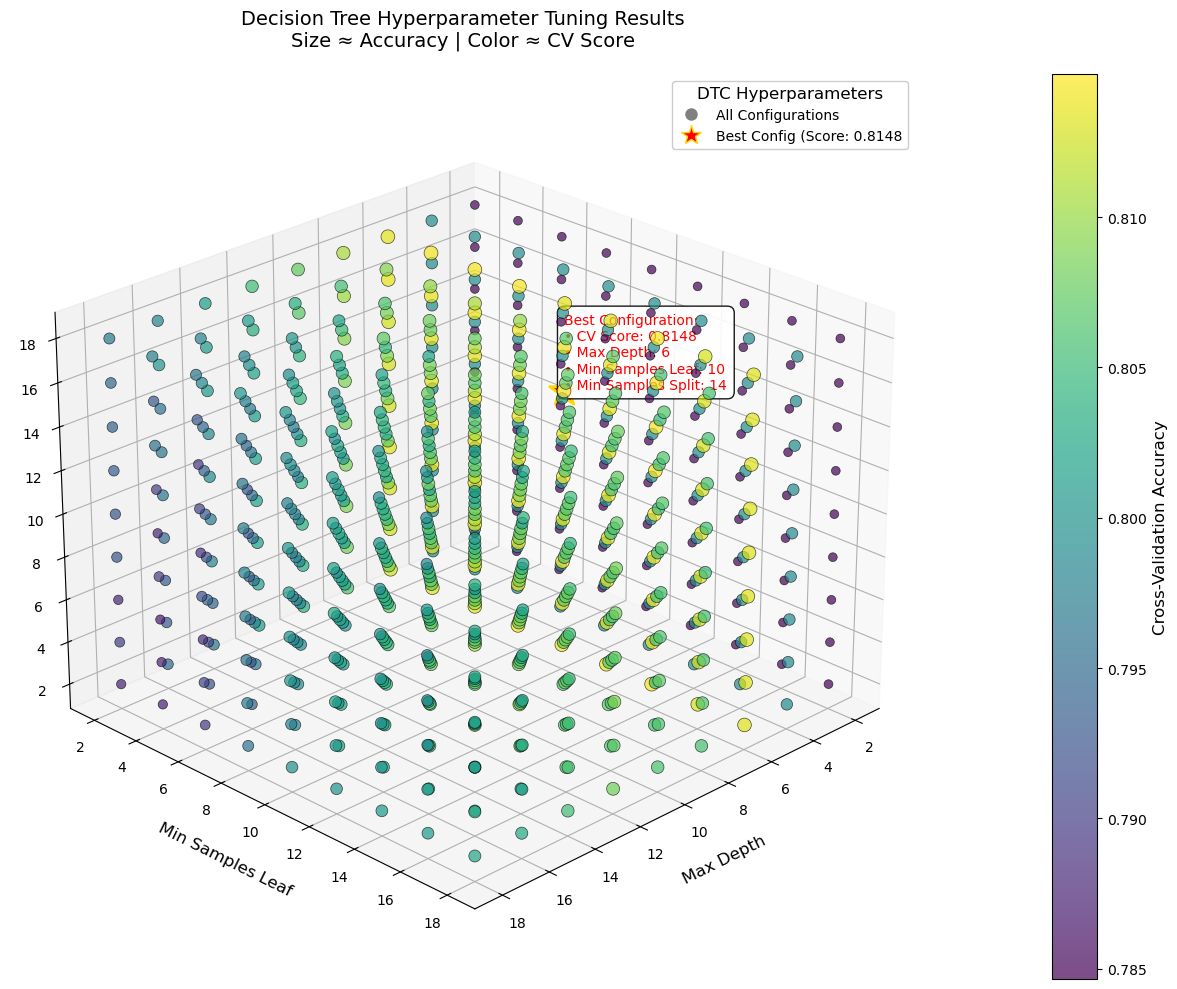

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.lines import Line2D

# Load DTC results
df = pd.read_csv('DTC_hyperparameter_tuning_results.csv')

# Get top 1 configuration
top1 = df.nlargest(1, 'mean_test_score')
print("Top Performing Configuration:")
print(top1[['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score']].to_string(index=False))

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Normalize scores for dynamic point sizing
score_min = df['mean_test_score'].min()
score_max = df['mean_test_score'].max()
score_range = max(score_max - score_min, 1e-6)  # Avoid division by zero

# Plot all points (single marker style)
sc = ax.scatter(
    df['param_max_depth'],
    df['param_min_samples_leaf'],
    df['param_min_samples_split'],
    c=df['mean_test_score'],
    cmap='viridis',
    marker='o',  # Uniform marker style
    s=40 + 60 * (df['mean_test_score'] - score_min) / score_range,
    alpha=0.7,
    edgecolor='k',
    linewidth=0.5
)

# Highlight the top 1 point
ax.scatter(
    top1['param_max_depth'],
    top1['param_min_samples_leaf'],
    top1['param_min_samples_split'],
    c='red',
    marker='*',
    s=500,
    edgecolor='gold',
    linewidth=2,
    alpha=1,
    zorder=10
)

# Label for top point
ax.text(
    top1['param_max_depth'].values[0] + 0.5,  # X-offset
    top1['param_min_samples_leaf'].values[0] + 0.5,  # Y-offset
    top1['param_min_samples_split'].values[0] + 0.5,  # Z-offset
    f"Best Configuration:\n"
    f"• CV Score: {top1['mean_test_score'].values[0]:.4f}\n"
    f"• Max Depth: {top1['param_max_depth'].values[0]}\n"
    f"• Min Samples Leaf: {top1['param_min_samples_leaf'].values[0]}\n"
    f"• Min Samples Split: {top1['param_min_samples_split'].values[0]}",
    color='red',
    fontsize=10,
    bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.5')
)

# Colorbar
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Cross-Validation Accuracy', fontsize=12)
cbar.mappable.set_clim(score_min, score_max)

# Custom legend (simplified)
legend_elements = [
    Line2D([0], [0],
           marker='o',
           color='w',
           markerfacecolor='gray',
           markersize=10,
           label='All Configurations'),
    Line2D([0], [0],
           marker='*',
           color='w',
           markerfacecolor='red',
           markeredgecolor='gold',
           markersize=15,
           label=f'Best Config (Score: {top1["mean_test_score"].values[0]:.4f}')
]

ax.legend(
    handles=legend_elements,
    title='DTC Hyperparameters',
    title_fontsize=12,
    fontsize=10,
    loc='upper right',
    framealpha=1
)

# Axis labels
ax.set_xlabel('Max Depth', fontsize=12, labelpad=10)
ax.set_ylabel('Min Samples Leaf', fontsize=12, labelpad=10)
ax.set_zlabel('Min Samples Split', fontsize=12, labelpad=10)

# Title
plt.title(
    'Decision Tree Hyperparameter Tuning Results\nSize ≈ Accuracy | Color ≈ CV Score',
    fontsize=14,
    pad=20
)

# Adjust view
ax.view_init(elev=25, azim=45)
plt.tight_layout()
plt.savefig('DTC_Top1_Configuration.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
data1[y_pred_1 == 1].to_csv("pred_exoplanets_dt.csv", index=False)

In [ ]:
pred_exoplanets=data1[y_pred_1 == 1]
planetorbit = pred_exoplanets['pl_orbper']
spo = np.sort(planetorbit)
list(spo)